# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# Metrics
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve, auc, accuracy_score, f1_score)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
class Config:
    SEED = 42
    MAX_ITER = 50000
    N_SPLIT = 1
    TEST_SIZE = 0.2

# Load Data

In [ ]:
link = "https://drive.google.com/file/d/1KtUYSsaKyWSuoqoxtK4vsOK6Dph57Mol/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (7043, 21)


# Data Preview and Info

In [ ]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nul

## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **dataset** contains **7043** samples with **20** columns, including the target variable `Churn`.

**Feature Overview**  
   - Both datasets include all important attributes:
     - **Numerical features:** `MonthlyCharges`, `TotalCharges`, `tenure`.
     - **Categorical features:** `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `Contract`, `PaperlessBilling`, `PaymentMethod`, `Churn`.
   - The target variable is **categorical** variable.

**Data Completeness**  
   - The dataset have **no missing values**.
   - Data types are appropriate: numerical features are int64 and float64 and categorical features is object.
   - We need to drop column customerID.

In [ ]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].str.strip(), errors="coerce")
num_features = ["MonthlyCharges", "TotalCharges", "tenure"]
cat_features = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
                "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.drop(columns=cat_features, axis=1).describe().T.style.background_gradient(cmap=cm))

Data describe:


,count,mean,std,min,25%,50%,75%,max
tenure,7043.000000,32.371149,24.559481,0.000000,9.000000,29.000000,55.000000,72.000000
MonthlyCharges,7043.000000,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
TotalCharges,7032.000000,2283.300441,2266.771362,18.800000,401.450000,1397.475000,3794.737500,8684.800000


## Descriptive Insights – Numerical Features

**Tenure**

* **Mean \~ 32.3 months**, with std \~ 24.5 → indicates moderate variation.
* 50% of customers have tenure between **9 → 55 months** (Q1–Q3).
* **Min = 0, Max = 72 months** → includes both brand-new and long-term loyal customers.

**MonthlyCharges**

* **Mean \~ 64.76 USD**, with std \~ 30.1 → suggests significant variation across service bundles.
* 50% of customers pay **35.5 → 89.9 USD** per month (Q1–Q3).
* **Min = 18.25, Max \~ 119 USD** → most subscriptions fall within the common range of 20–120 USD.

**TotalCharges**

* **Mean \~ 2,283.3 USD**, with std \~ 2,266.7 → large variation driven by differences in **tenure**.
* 50% of customers have accumulated charges between **401 → 3,794 USD** (Q1–Q3).
* **Min \~ 18, Max \~ 8685 USD** → reflects both new customers with small payments and long-term customers with very high spend.

In [ ]:
# SeniorCitizen
choices_SeniorCitizen = ["No", "Yes"]
conditions = [
    (df["SeniorCitizen"] == 0),
    (df["SeniorCitizen"] == 1)
]
df["SeniorCitizen"] = np.select(conditions, choices_SeniorCitizen, default="Unknown")

def convert_cat(features, df = df):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
convert_cat(cat_features)

# Display information about the DataFrames
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBill

In [ ]:
list_features_drop = ["MonthlyCharges", "TotalCharges", "tenure", "Churn"]
print("Data describe:")
cat_summary = df.drop(columns=list_features_drop, axis=1).describe().T
cat_summary.style.background_gradient(cmap="Blues", subset=["unique", "freq"])

Data describe:


,count,unique,top,freq
customerID,7043,7043,3186-AJIEK,1
gender,7043,2,Male,3555
SeniorCitizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


## Categorical Feature Insights

* **Gender**

  * 2 categories: Male (3,555) and Female (3,488).
  * Distribution is quite **balanced** between genders.
  * Unlikely to be a strong predictor of churn.

* **SeniorCitizen**

  * 2 categories: Yes (1,142), No (5,901).
  * The majority are **non-senior** customers.
  * May reflect the role of **age** in service usage behavior.

* **Partner**

  * 2 categories: Yes (3,061), No (3,641).
  * More customers **without a partner**.
  * Marital status may influence **contract stability**.

* **Dependents**

  * 2 categories: Yes (2,103), No (4,940).
  * Most customers **do not have dependents**.
  * Suggests household structure could impact churn.

* **PhoneService**

  * 2 categories: Yes (6,361), No (742).
  * The majority have **phone service**.
  * Indicates phone remains a common service.

* **MultipleLines**

  * 3 categories: Yes (3,399), No (3,308), No phone service (742).
  * Fairly even distribution between **Yes** and **No**.
  * "No phone service" is a small group, aligned with those not subscribed to PhoneService.

* **InternetService**

  * 3 categories: DSL (2,421), Fiber optic (3,098), No (1,184).
  * **Fiber optic** is the most common internet type.
  * Type of internet is expected to be an important factor in churn analysis.

* **OnlineSecurity**

  * 3 categories: Yes (2,013), No (3,989), No internet service (1,184).
  * The majority **do not use OnlineSecurity**.
  * Likely associated with churn due to lack of value-added services.

* **OnlineBackup**

  * 3 categories: Yes (2,076), No (3,943), No internet service (1,184).
  * Similar to OnlineSecurity, **No** is the largest group.
  * Shows customers are not fully adopting add-on services.

* **DeviceProtection**

  * 3 categories: Yes (2,009), No (3,958), No internet service (1,184).
  * Same trend as OnlineBackup/OnlineSecurity.
  * Customers are generally **less inclined to choose device protection**.

* **TechSupport**

  * 3 categories: Yes (2,043), No (3,956), No internet service (1,184).
  * **No TechSupport** is the majority.
  * Could affect customer experience and churn.

* **StreamingTV**

  * 3 categories: Yes (2,815), No (3,042), No internet service (1,184).
  * Distribution is fairly balanced between **Yes** and **No**.
  * Suggests streaming services have moderate adoption.

* **StreamingMovies**

  * 3 categories: Yes (2,775), No (3,064), No internet service (1,184).
  * Similar to StreamingTV, customers are evenly split.
  * Online entertainment services may play a role in retention.

* **Contract**

  * 3 categories: Month-to-month (3,875), One year (1,472), Two year (1,656).
  * **Month-to-month dominates** the customer base.

* **PaperlessBilling**

  * 2 categories: Yes (4,174), No (2,929).
  * The majority opt for **PaperlessBilling**.
  * Relates to the level of **digital engagement**.

* **PaymentMethod**

  * 4 categories: Electronic check (2,365), Mailed check (1,598), Bank transfer (1,542), Credit card (1,238).
  * **Electronic check** is the most common method.

# Data Quality Checks

## Missing Value

In [ ]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value dataset: ")
displayNULL(df, dataset_name="Dataset")

Missing value dataset: 
🔎 Missing Value Summary for: Dataset
+--------------+---------------+-----------+
| Feature      | Missing_Count | Missing_% |
+--------------+---------------+-----------+
| TotalCharges | 11            | 0.16      |
+--------------+---------------+-----------+

⚠️  Total missing values: 11 out of 7,043 rows.


In [ ]:
df["TotalCharges"] = df["TotalCharges"].fillna(df.TotalCharges.median())
print("Missing value dataset: ")
displayNULL(df, dataset_name="Dataset")

Missing value dataset: 
🔎 Missing Value Summary for: Dataset
✅ No missing values detected in 7,043 rows.


## Checking duplicate Value

In [ ]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }

🔍 Data Duplicate Analysis
✅ No duplicates found in 7,043 rows


## Checking Outlier Value

In [ ]:
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []

    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]

        if len(outliers) > 0:
            outlier_info.append({
                "Feature": feature,
                "Outlier Count": len(outliers),
                # "Outlier Detail": outliers.tolist()
            })

    if len(outlier_info) == 0:
        print("✅ No outliers detected in the selected features.")
    else:
        return pd.DataFrame(outlier_info)

checking_outlier(list_feature=num_features, df=df, dataset_name="Data")

🔍 Data Checking outlier
✅ No outliers detected in the selected features.


In [ ]:
df.drop(columns="customerID", axis=1, inplace=True)

## Data Quality Insights: Missing Values, Duplicates and Outliers.

**Missing Values Analysis**

* We conducted a thorough examination for missing values in the dataset.

* **The missing values** were detected and updated — ensuring clean synthetic data for model training.

**Duplicate Records Analysis**

* We performed a check for exact duplicate rows that could artificially inflate performance or introduce bias.

  * **No duplicates** detected in 7043 rows — ensuring test predictions are made on unique samples.

**Outlier Analysis**

* We also examined the datasets for checking outliers.
* **The no outliers** were found in dataset at features.

# Churn Status Distribution

In [ ]:
def color(n_colors=2):
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    positions = np.linspace(0, 1, n_colors)
    colors = [cmap(p) for p in positions]
    return colors

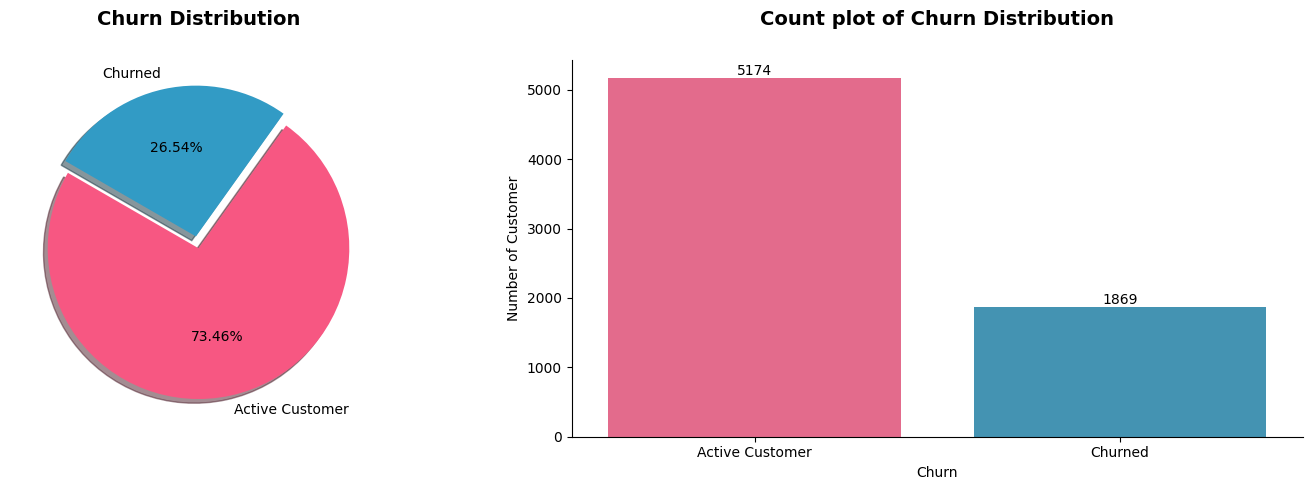

In [ ]:
churn_Distribution  = df["Churn"].value_counts()
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15, 5))
n_color = color(n_colors=df["Churn"].nunique())
# ax[0]
ax[0].pie(
    churn_Distribution,
    labels = ["Active Customer", "Churned"],
    colors = n_color,
    autopct = "%1.2f%%",
    startangle = 150,
    explode = (0, 0.08),
    shadow= True
)
ax[0].set_title("Churn Distribution",  weight="bold", fontsize=14, pad=25)

# ax[1]
sns.countplot(data=df, x = "Churn", palette=n_color, hue="Churn",
              ax=ax[1])
ax[1].set_title("Count plot of Churn Distribution", weight="bold", fontsize=14, pad=25)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%d", label_type="edge", fontsize=10)
ax[1].set_ylabel("Number of Customer")
ax[1].set_xticks([0, 1], ["Active Customer", "Churned"])
ax[1].set_xlabel("Churn")
sns.despine(ax=ax[1], top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()

### Insights into Churn Distribution

**Frequency of churn categories**

* The pie chart and count plot show the distribution of churn labels.
* `Active Customer` accounts for **5,174 records (\~73.46%)**.
* `Churned` customers account for **1,869 records (\~26.54%)**.

***The dataset is clearly imbalanced, with significantly more active customers than churned ones. This imbalance may challenge machine learning models, as they could be biased toward predicting the majority class (active customers). To ensure robust churn prediction, techniques such as resampling (oversampling churned customers or undersampling active ones), applying class weights, or using ensemble methods may be necessary to mitigate bias and improve prediction accuracy on the minority churn class.***

# Data PreProcessing

## Encode

In [ ]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
df["Churn"] = df["Churn"].astype("int8")

num_features = ["MonthlyCharges", "TotalCharges", "tenure"]
cat_features = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
                "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                "Contract", "PaperlessBilling", "PaymentMethod"]

df = pd.get_dummies(df, columns=cat_features, drop_first=False)
bool_cols = df.select_dtypes(include="bool").columns
df[bool_cols] = df[bool_cols].astype("int8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   Churn                                    7043 non-null   int8   
 4   gender_Female                            7043 non-null   int8   
 5   gender_Male                              7043 non-null   int8   
 6   SeniorCitizen_No                         7043 non-null   int8   
 7   SeniorCitizen_Yes                        7043 non-null   int8   
 8   Partner_No                               7043 non-null   int8   
 9   Partner_Yes                              7043 non-null   int8   
 10  Dependents_No                            7043 no

## TRAIN TEST SPLIT

In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
print(X_train.shape, X_val.shape)

(5634, 46) (1409, 46)


## SCALE DATA

In [ ]:
num_stand_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_keep_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num_stand", num_stand_transformer, num_features),
    ("cat_keep", cat_keep_transformer, bool_cols),
])

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_re_scale = preprocessor.fit_transform(X_train_resampled)
X_val_re_scale = preprocessor.transform(X_val)

list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_stand__MonthlyCharges',
 'num_stand__TotalCharges',
 'num_stand__tenure',
 'cat_keep__gender_Female',
 'cat_keep__gender_Male',
 'cat_keep__SeniorCitizen_No',
 'cat_keep__SeniorCitizen_Yes',
 'cat_keep__Partner_No',
 'cat_keep__Partner_Yes',
 'cat_keep__Dependents_No',
 'cat_keep__Dependents_Yes',
 'cat_keep__PhoneService_No',
 'cat_keep__PhoneService_Yes',
 'cat_keep__MultipleLines_No',
 'cat_keep__MultipleLines_No phone service',
 'cat_keep__MultipleLines_Yes',
 'cat_keep__InternetService_DSL',
 'cat_keep__InternetService_Fiber optic',
 'cat_keep__InternetService_No',
 'cat_keep__OnlineSecurity_No',
 'cat_keep__OnlineSecurity_No internet service',
 'cat_keep__OnlineSecurity_Yes',
 'cat_keep__OnlineBackup_No',
 'cat_keep__OnlineBackup_No internet service',
 'cat_keep__OnlineBackup_Yes',
 'cat_keep__DeviceProtection_No',
 'cat_keep__DeviceProtection_No internet service',
 'cat_keep__DeviceProtection_Yes',
 'cat_keep__TechSupport_No',
 'cat_keep__TechSupport_No internet service',


# Modeling

In [ ]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)
models = [
    LogisticRegression(solver="liblinear", max_iter=Config.MAX_ITER, random_state=Config.SEED),
    RandomForestClassifier(n_estimators=100, random_state=Config.SEED),
    ExtraTreesClassifier(random_state=Config.SEED),
    AdaBoostClassifier(random_state=Config.SEED),
    XGBClassifier(n_estimators= 2000, max_depth= 4, eval_metric = "logloss",
                  random_state=Config.SEED, min_child_weight= 2, gamma=0.9,
                  subsample=0.8, colsample_bytree=0.8, objective= "binary:logistic",
                  nthread= -1),
    GradientBoostingClassifier(random_state=Config.SEED),
    CatBoostClassifier(verbose=0, random_seed=Config.SEED, allow_writing_files=False),
    BaggingClassifier(random_state=Config.SEED),
    LGBMClassifier(random_state=Config.SEED, verbosity=-1),
    HistGradientBoostingClassifier(random_state=Config.SEED, max_iter=Config.MAX_ITER)
]

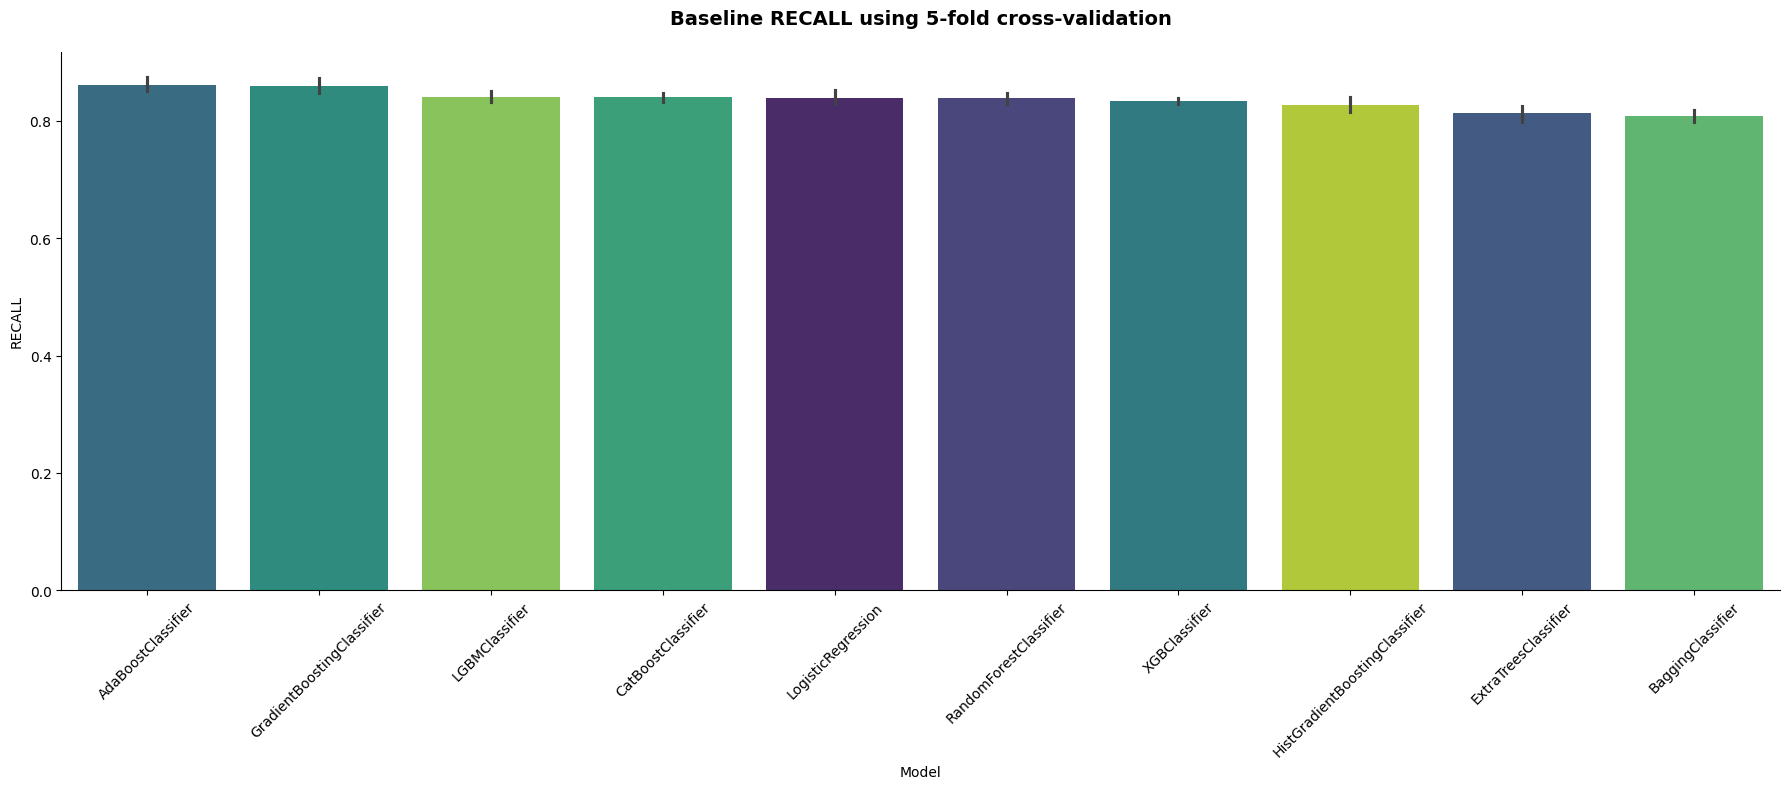

,Mean,Std,N
model_name,,,
AdaBoostClassifier,0.861807,0.013788,5
GradientBoostingClassifier,0.859151,0.017379,5
LGBMClassifier,0.841271,0.012502,5
CatBoostClassifier,0.840303,0.010659,5
LogisticRegression,0.838615,0.016636,5
RandomForestClassifier,0.838370,0.012362,5
XGBClassifier,0.834262,0.006785,5
HistGradientBoostingClassifier,0.826776,0.016937,5
ExtraTreesClassifier,0.813727,0.017460,5


In [ ]:
def generate_baseline_results(models=models, X=X_train_re_scale, y=y_train_resampled,
                              metric="recall", cv=kfold, plot_result=False):

    X_ = X.toarray() if hasattr(X, "toarray") else X
    entries = []
    for model in models:
        model_name = getattr(model, "name", model.__class__.__name__)
        scores = cross_val_score(model, X_, y, scoring=metric, cv=cv, n_jobs=-1)
        for fold_idx, s in enumerate(scores, start=1):
            entries.append((model_name, fold_idx, s))

    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_id", "score"])

    summary = (cv_df.groupby("model_name")["score"]
                    .agg(Mean="mean", Std="std", N="size")
                    .sort_values("Mean", ascending=False))

    if plot_result:
        order = summary.index.tolist()
        plt.figure(figsize=(18, 8))
        sns.barplot(data=cv_df, x="model_name", y="score", order=order, palette="viridis", hue="model_name")
        sns.despine()
        title_metric = metric.upper() if isinstance(metric, str) else "Score"
        nfolds = getattr(cv, "n_splits", "CV")
        plt.title(f"Baseline {title_metric} using {nfolds}-fold cross-validation", fontsize=14, weight="bold", pad=20)
        plt.xlabel("Model"); plt.ylabel(title_metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return summary

generate_baseline_results(plot_result = True)

# Hyper Parameter Tunning

In [ ]:
def plot_ROC_confusionMatrix(estimator, X_val, y_val, figsize=(12, 8)):
    RESET = "\033[0m"
    BLUE = "\033[94m"

    # Refer on Kaggel
    if estimator.__class__.__name__ == "SVC" and hasattr(estimator, "predict_proba"):
        y_pred_prob = estimator.predict_proba(X_val)[:, 1]
    elif estimator.__class__.__name__ in ["SVC", "LinearSVC", "RidgeClassifier"]:
        y_pred_prob = estimator.decision_function(X_val)
    else:
        y_pred_prob = estimator.predict_proba(X_val)[:, 1]

    y_pred = estimator.predict(X_val)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # --- Plot 1: ROC ---
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    rocScore = roc_auc_score(y_val, y_pred_prob)
    print(f"ROC AUC Score: {BLUE}{rocScore:.2f}{RESET}")
    print("-" * 80)

    f1_macro  = f1_score(y_val, y_pred, average="macro")
    print(f"F1 Macro Score: {BLUE}{f1_macro:.2f}{RESET}")
    print("-" * 80)

    f1_weighted  = f1_score(y_val, y_pred, average="weighted")
    print(f"F1 Weighted Score: {BLUE}{f1_weighted:.2f}{RESET}")
    print("-" * 80)

    ax[0, 0].plot(fpr, tpr, label=f"{estimator.__class__.__name__} (AUC = {rocScore:.2f})")
    ax[0, 0].plot([0, 1], [0, 1], "b--")
    ax[0, 0].set_xlabel("False Positive Rate")
    ax[0, 0].set_ylabel("True Positive Rate")
    ax[0, 0].set_title(f"ROC ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 0].legend()

    # --- Plot 2: Confusion Matrix ---
    confusionMatrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 1])
    ax[0, 1].set_title(f"Confusion Matrix ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 1].set_xlabel("Prediction")
    ax[0, 1].set_ylabel("Actual")

    # --- Plot 3: Precision-Recall Curve ---
    precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_prob)
    pr_auc = auc(recall, precision)
    print(f"PR AUC Score: {BLUE}{pr_auc:.2f}{RESET}")
    print("-" * 80)
    ax[1, 0].plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
    ax[1, 0].set_xlabel("Recall")
    ax[1, 0].set_ylabel("Precision")
    ax[1, 0].set_title("Precision-Recall Curve", fontsize=14, weight="bold", pad=20)
    ax[1, 0].legend()

    ax[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(classification_report(y_val, y_pred))

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val, figsize = (15, 6)):
    print(f"Evaluating {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    plot_ROC_confusionMatrix(estimator = model, X_val = X_val, y_val = y_val, figsize = figsize)

## GradientBoostingClassifier

Evaluating GradientBoostingClassifier...
ROC AUC Score: 0.83
--------------------------------------------------------------------------------
F1 Macro Score: 0.70
--------------------------------------------------------------------------------
F1 Weighted Score: 0.74
--------------------------------------------------------------------------------
PR AUC Score: 0.61
--------------------------------------------------------------------------------


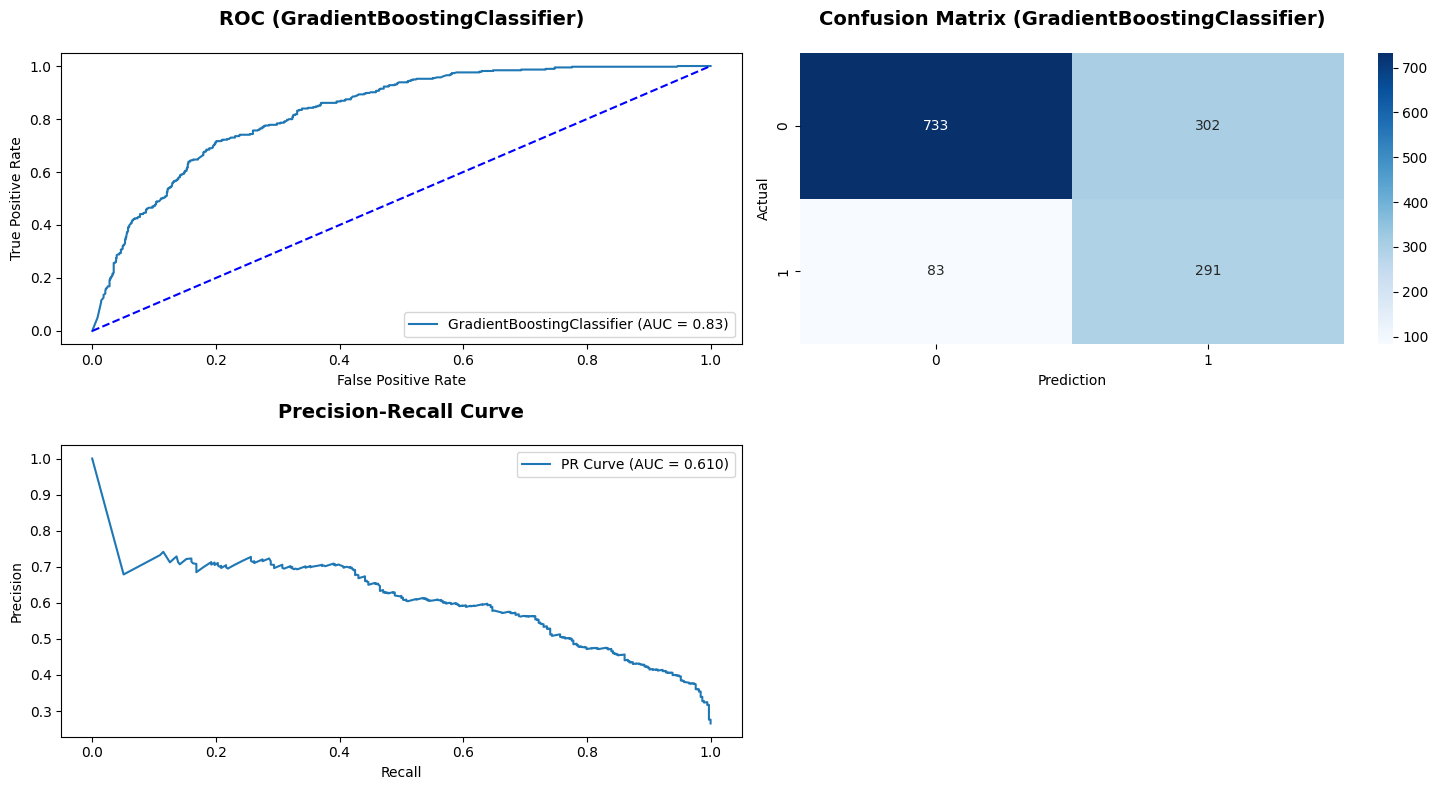

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.74      1409



In [ ]:
param_gbc = {
    "n_estimators": 64,
    "learning_rate": 0.01416620141101869,
    "max_depth": 3,
    "min_samples_split": 14,
    "min_samples_leaf": 4,
    "subsample": 0.5144994427348626,
    "max_features": None,
    "random_state": 42
}

model_gbc = GradientBoostingClassifier(**param_gbc)
evaluate_model(model_gbc, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

## RandomForestClassifier

Evaluating RandomForestClassifier...
ROC AUC Score: 0.84
--------------------------------------------------------------------------------
F1 Macro Score: 0.72
--------------------------------------------------------------------------------
F1 Weighted Score: 0.77
--------------------------------------------------------------------------------
PR AUC Score: 0.62
--------------------------------------------------------------------------------


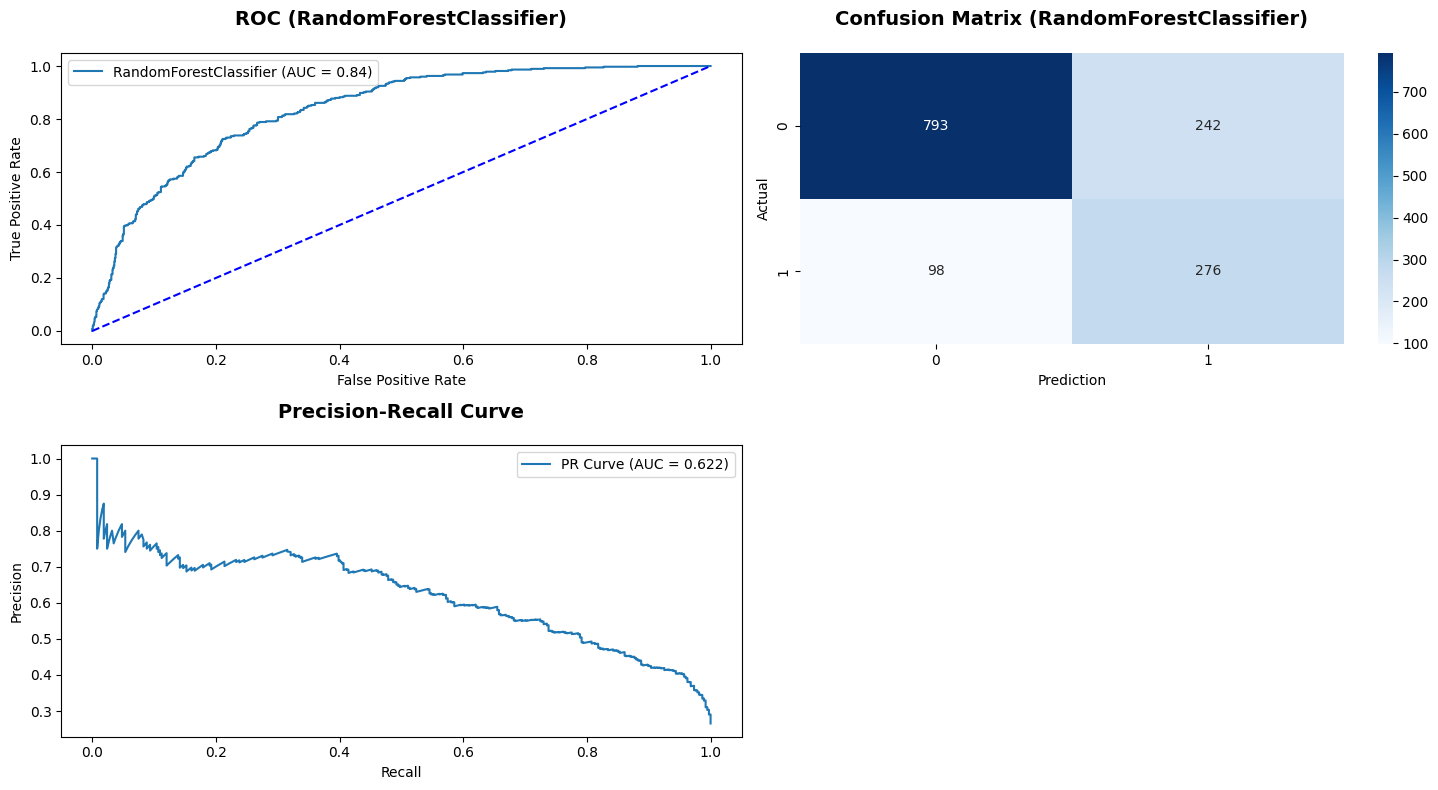

              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [ ]:
param_rf = {
    "n_estimators": 600,
    "max_depth": 6,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "bootstrap": False,
    "random_state": 42,
    "n_jobs": -1
}

model_rf = RandomForestClassifier(**param_rf)
evaluate_model(model_rf, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

## AdaBoostClassifier

Evaluating AdaBoostClassifier...
ROC AUC Score: 0.76
--------------------------------------------------------------------------------
F1 Macro Score: 0.49
--------------------------------------------------------------------------------
F1 Weighted Score: 0.48
--------------------------------------------------------------------------------
PR AUC Score: 0.62
--------------------------------------------------------------------------------


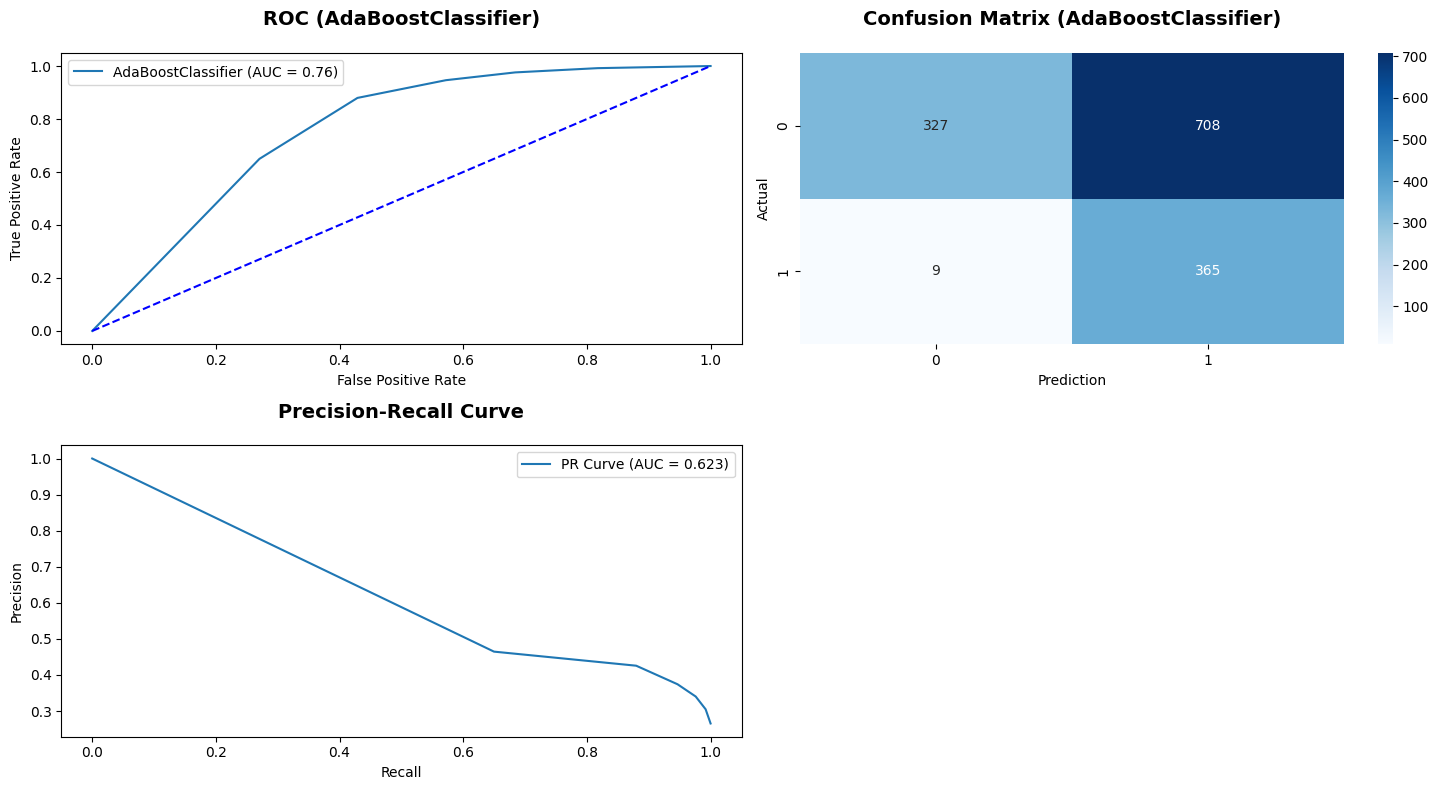

              precision    recall  f1-score   support

           0       0.97      0.32      0.48      1035
           1       0.34      0.98      0.50       374

    accuracy                           0.49      1409
   macro avg       0.66      0.65      0.49      1409
weighted avg       0.81      0.49      0.48      1409



In [ ]:
param_ab =  {"n_estimators": 50, "learning_rate": 0.013977966894633036}

model_ab = AdaBoostClassifier(random_state=42, **param_ab)
evaluate_model(model_ab, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

## XGBClassifier

Evaluating XGBClassifier...
ROC AUC Score: 0.83
--------------------------------------------------------------------------------
F1 Macro Score: 0.70
--------------------------------------------------------------------------------
F1 Weighted Score: 0.75
--------------------------------------------------------------------------------
PR AUC Score: 0.61
--------------------------------------------------------------------------------


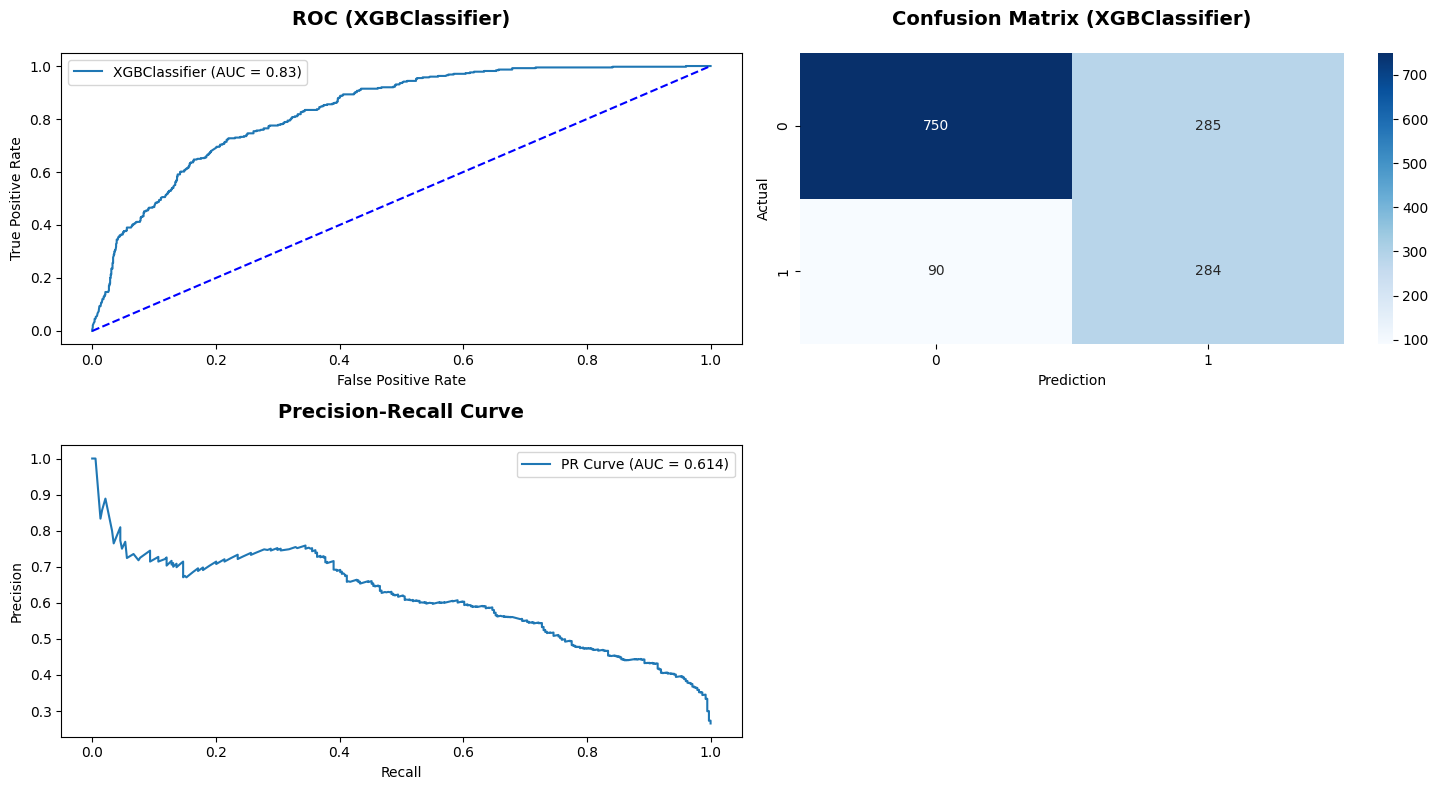

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1035
           1       0.50      0.76      0.60       374

    accuracy                           0.73      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.79      0.73      0.75      1409



In [ ]:
param_xgb =  {
    "n_estimators": 150,
    "max_depth": 3,
    "learning_rate": 0.010727016584187236,
    "subsample": 0.8214933852768715,
    "colsample_bytree": 0.5198385186784911,
    "gamma": 4.07183554608734,
    "reg_alpha": 1.9898324739351712,
    "reg_lambda": 2.1365638497821093
}

model_xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        **param_xgb
    )
evaluate_model(model_xgb, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

## LGBMClassifier

Evaluating LGBMClassifier...
ROC AUC Score: 0.82
--------------------------------------------------------------------------------
F1 Macro Score: 0.69
--------------------------------------------------------------------------------
F1 Weighted Score: 0.73
--------------------------------------------------------------------------------
PR AUC Score: 0.59
--------------------------------------------------------------------------------


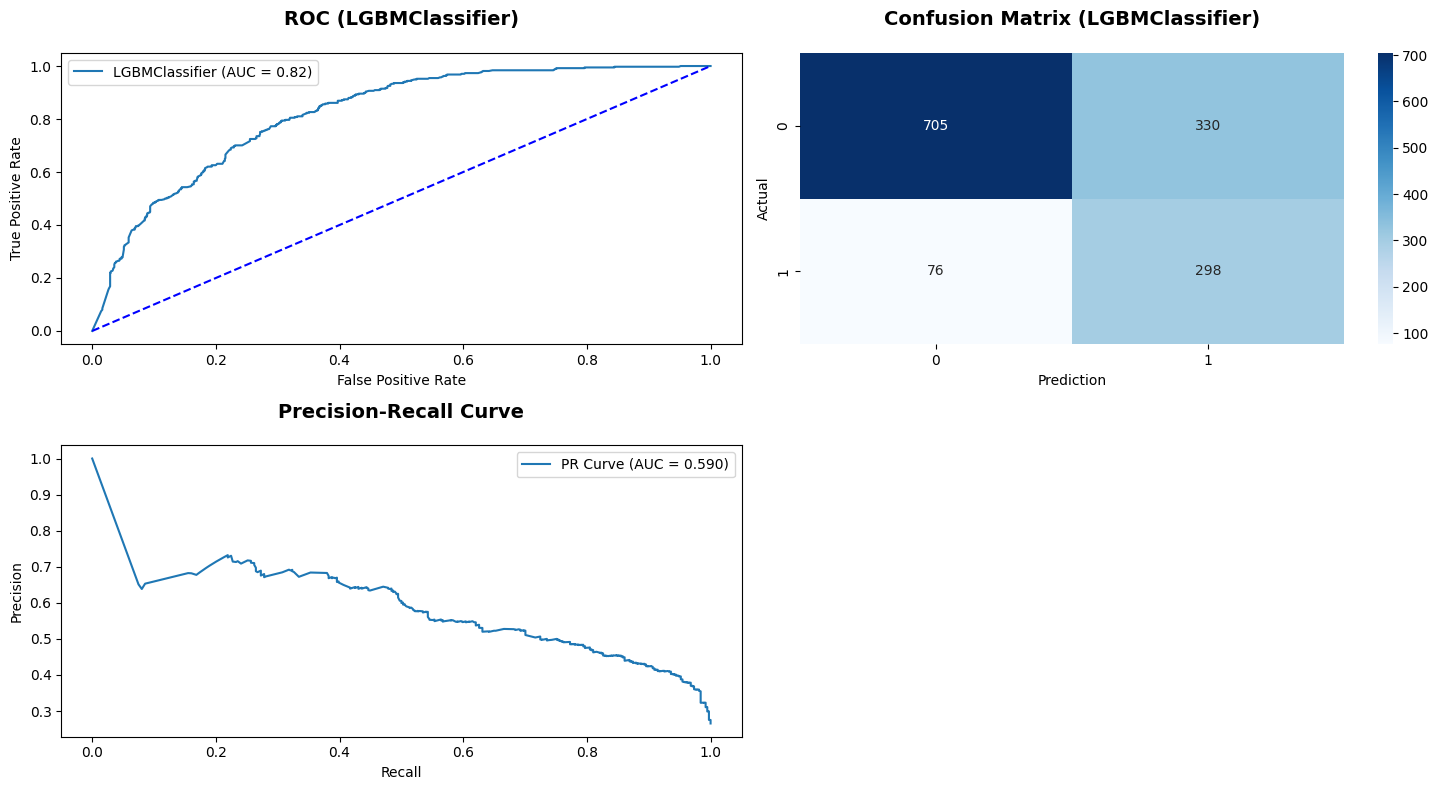

              precision    recall  f1-score   support

           0       0.90      0.68      0.78      1035
           1       0.47      0.80      0.59       374

    accuracy                           0.71      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.71      0.73      1409



In [ ]:
param_lgbm =  {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.010785706957277664,
    "num_leaves": 143,
    "min_child_samples": 15,
    "subsample": 0.7076106889990836,
    "colsample_bytree": 0.7833148308125816,
    "reg_alpha": 2.1387030130824276,
    "reg_lambda": 2.4623170917015758
}

model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose = -1, **param_lgbm)
evaluate_model(model_lgbm, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

## CatBoostClassifier

Evaluating CatBoostClassifier...
ROC AUC Score: 0.84
--------------------------------------------------------------------------------
F1 Macro Score: 0.73
--------------------------------------------------------------------------------
F1 Weighted Score: 0.78
--------------------------------------------------------------------------------
PR AUC Score: 0.65
--------------------------------------------------------------------------------


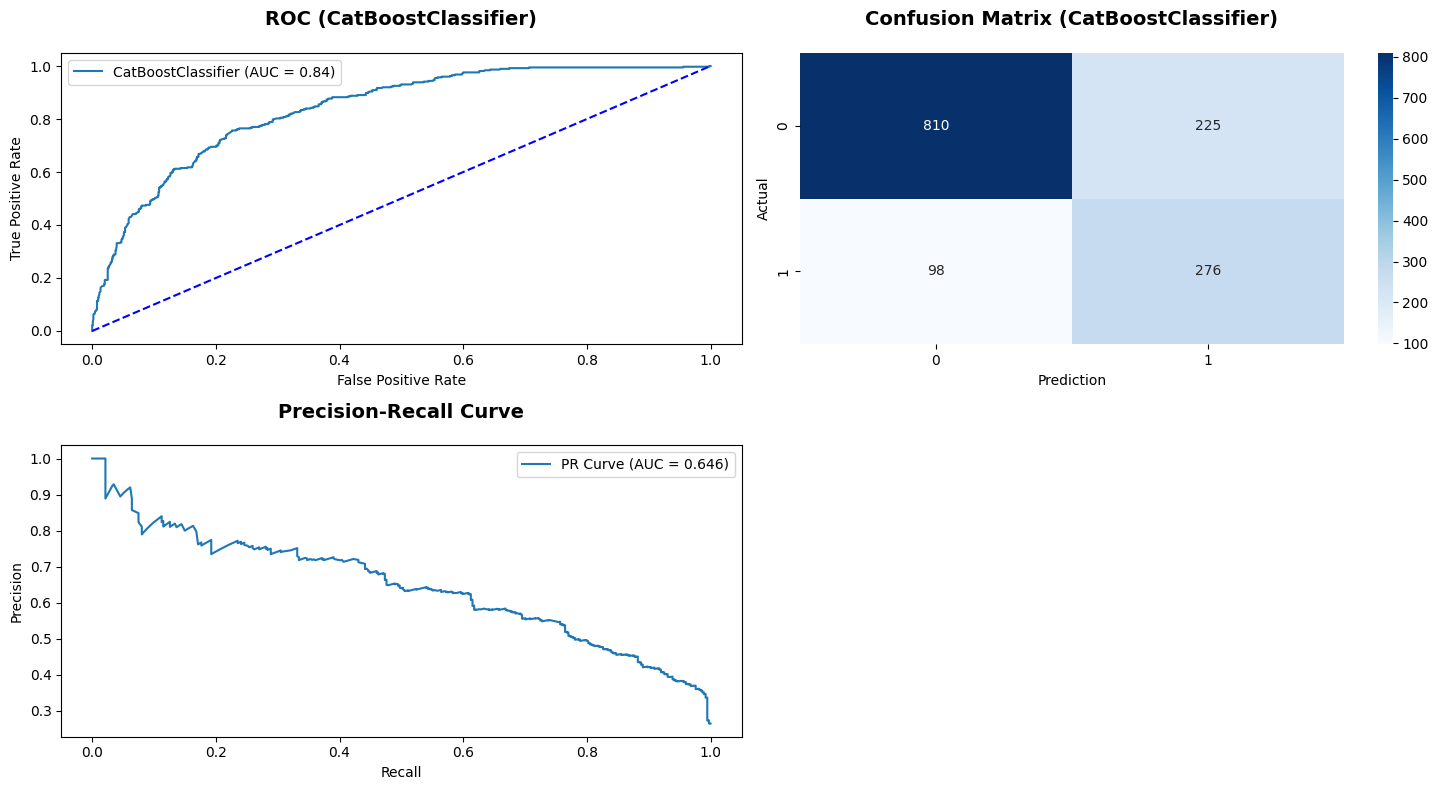

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [ ]:
param_cb =  {
    "iterations": 147,
    "learning_rate": 0.010013940567559257,
    "depth": 3,
    "l2_leaf_reg": 6.258466284384178,
    "border_count": 117,
    "random_strength": 1.2746779271935665e-09,
    "bagging_temperature": 0.7485075712054384
}

model_cb = CatBoostClassifier(random_state=42, verbose=0, **param_cb)
evaluate_model(model_cb, X_train_re_scale, X_val_re_scale, y_train_resampled, y_val, figsize = (15, 8))

  <p align="center">
    <img src="https://i.ibb.co/WvJ3VsWx/8-confusion-matrix-python.webp" width="600">
  </p>

> **"Here, I use recall as the metric to optimize for churned customers, and clearly the AdaBoost model returns a very high number of correctly predicted churned customers (365 out of 374), but it also has a high number of incorrect predictions for class 0 (high false positives)."**


# Feature Impotance

## GradientBoostingClassifier

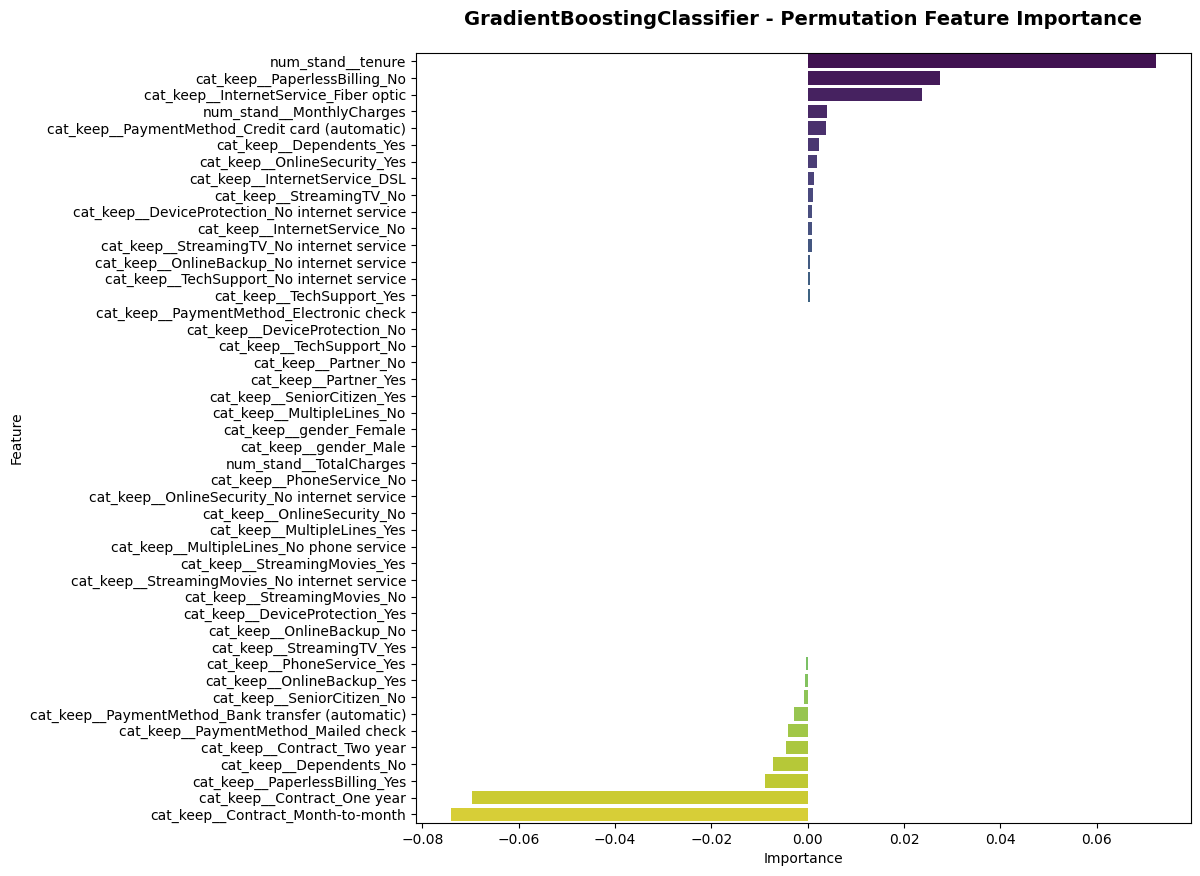

In [ ]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    model_gbc, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("GradientBoostingClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## RandomForestClassifier

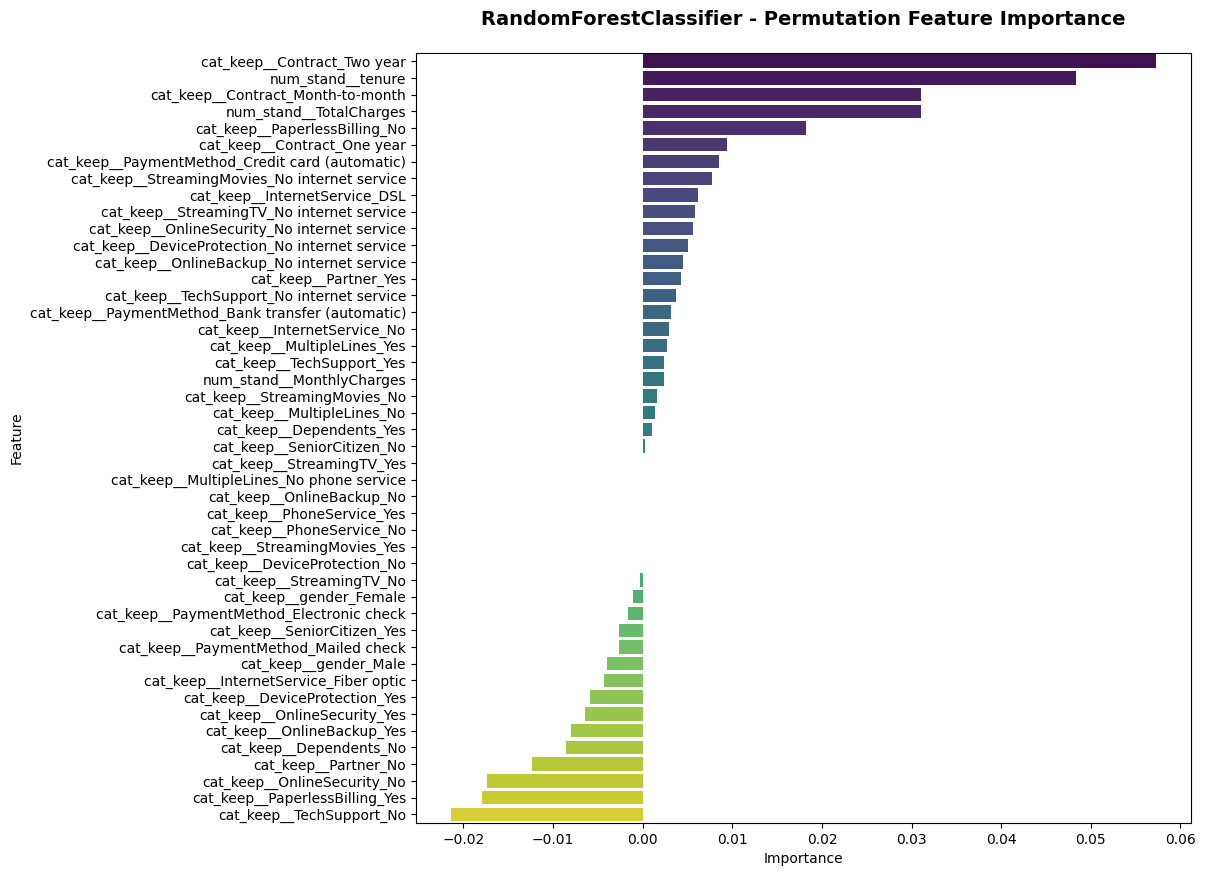

In [ ]:
result = permutation_importance(
    model_rf, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("RandomForestClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## AdaBoostClassifier

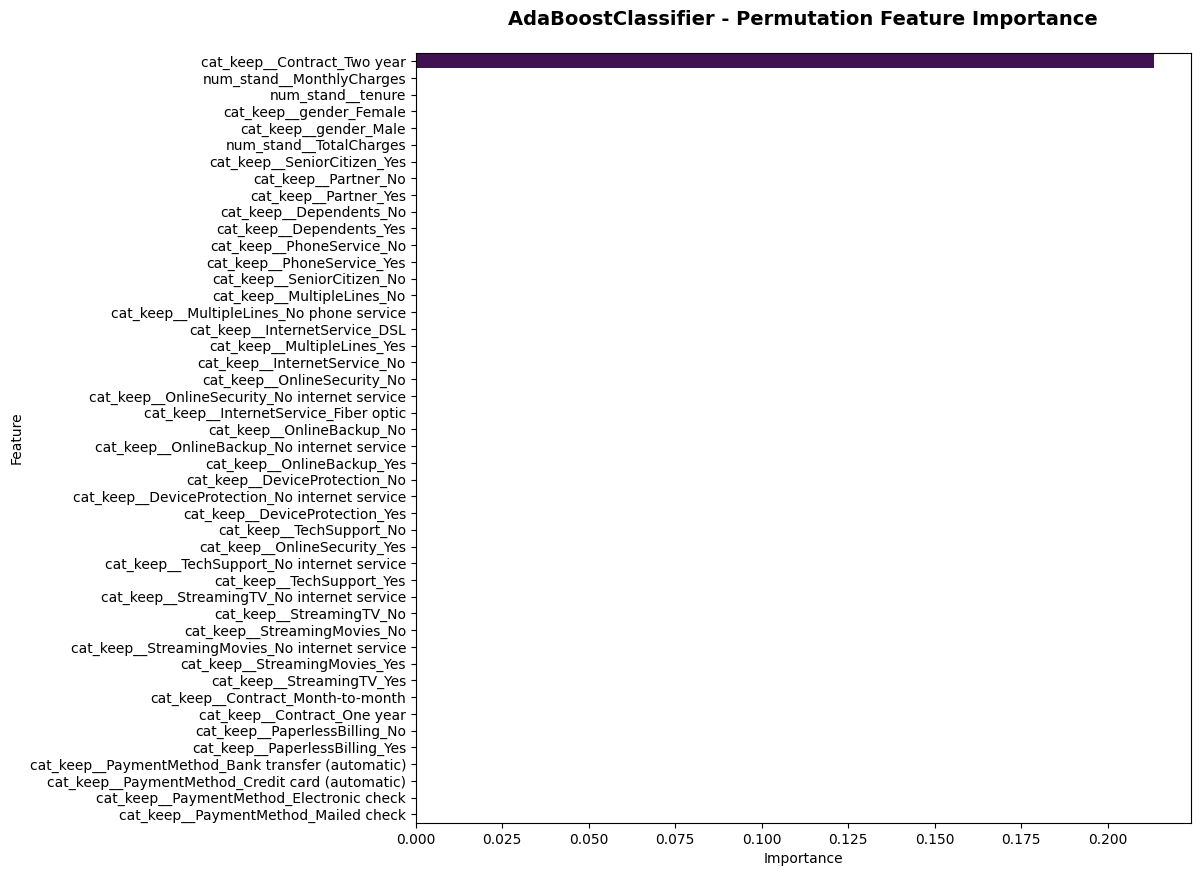

In [ ]:
result = permutation_importance(
    model_ab, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("AdaBoostClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## XGBClassifier

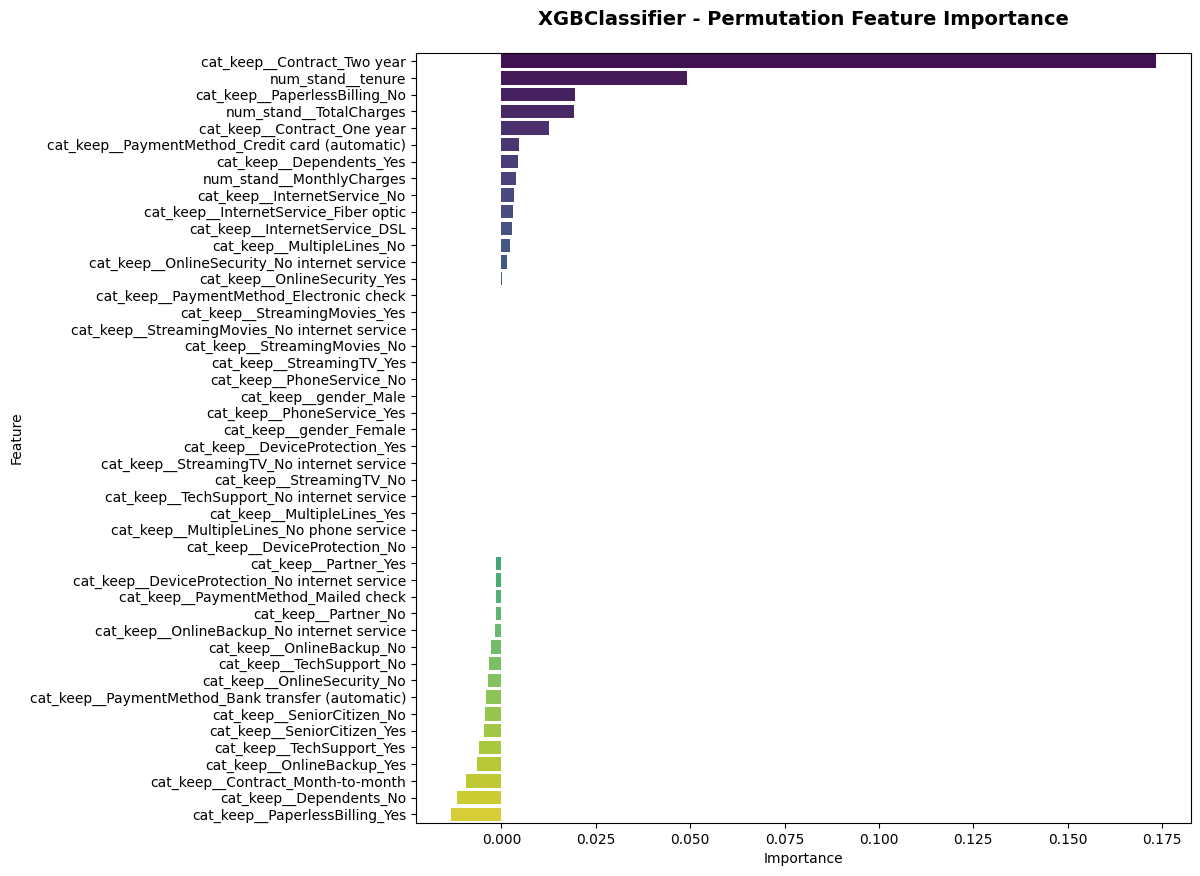

In [ ]:
result = permutation_importance(
    model_xgb, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("XGBClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## LGBMClassifier

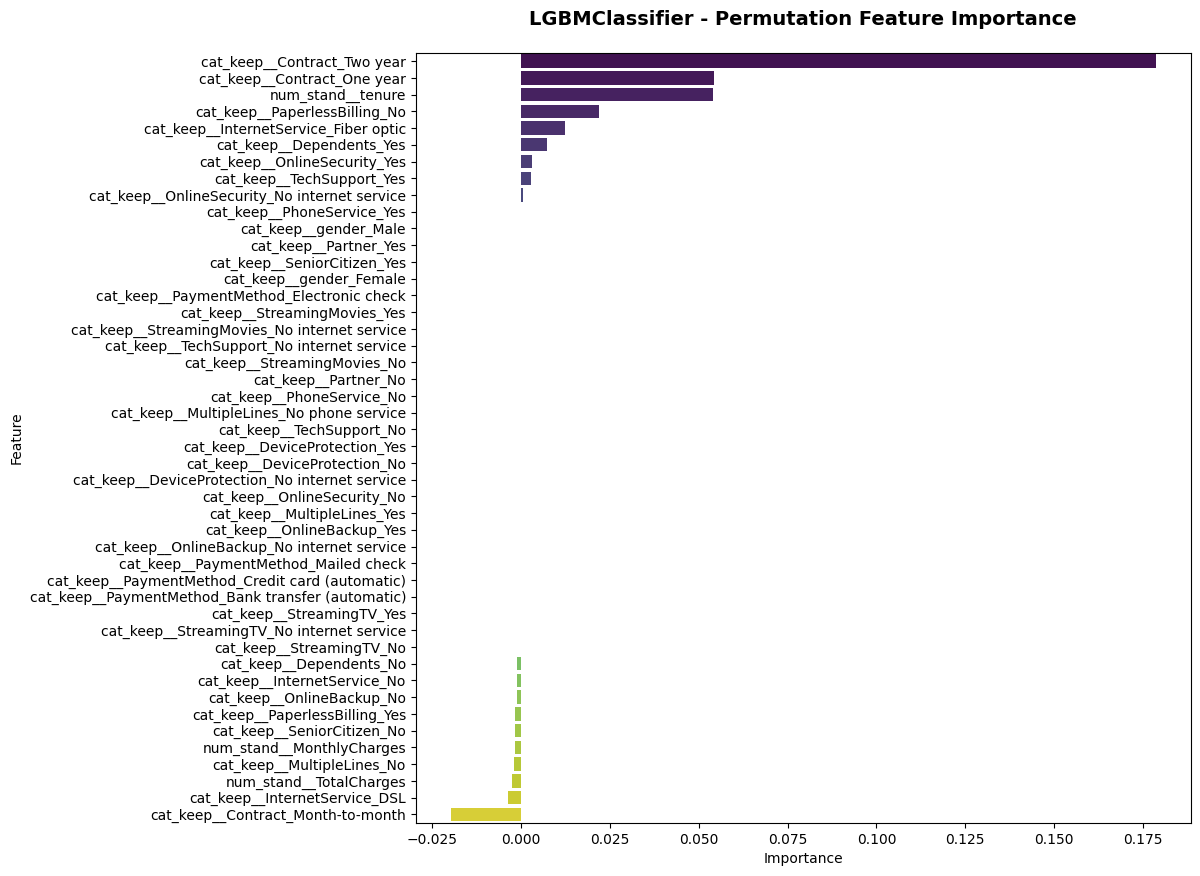

In [ ]:
result = permutation_importance(
    model_lgbm, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("LGBMClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## CatBoostClassifier

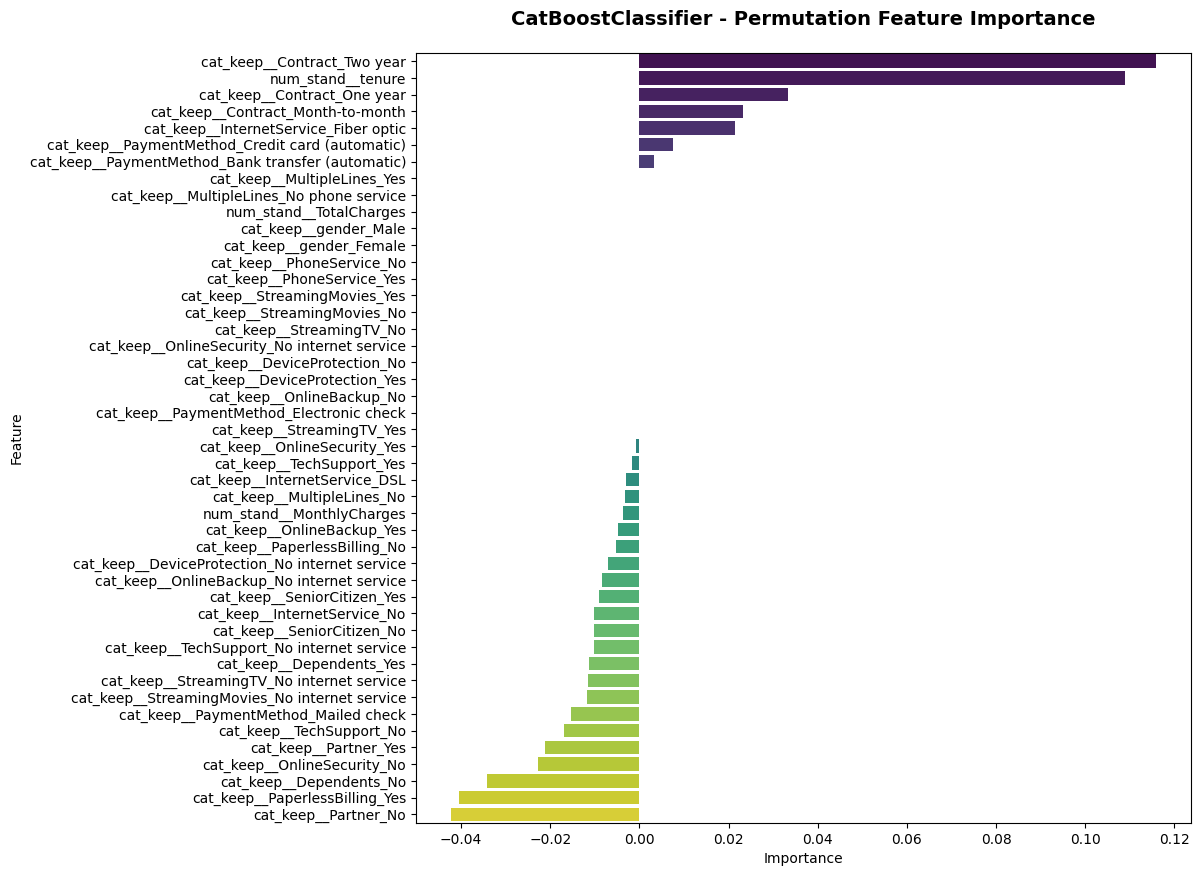

In [ ]:
result = permutation_importance(
    model_cb, X_val_re_scale, y_val, n_repeats=10, random_state=42, scoring="recall"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("CatBoostClassifier - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()